In [1]:
import sys; sys.path += ['..']
from brain_data import nsd_parser

In [2]:
import pandas as pd
import numpy as np
%matplotlib inline

import matplotlib as mpl
import matplotlib.pyplot as plt

import nibabel as nib
import cortex # pycortex

from copy import deepcopy
from glob import glob
from tqdm.auto import tqdm

from IPython.display import display, HTML
from matplotlib.colors import LinearSegmentedColormap

### Define Flatmap Helpers

In [3]:
def get_flatmap(map_data, figsize=(20,10), **kwargs):
    roi_list = ['EarlyVis','OPA','EBA','PPA','OWFA',
                'FFA-1','FFA-2','FBA-1','FBA-2']

    roi_list = kwargs.pop('roi_list', roi_list)

    standard_kwargs = {'roi_list': roi_list,
                       'sampler': 'nearest',
                       'with_colorbar': False,
                       'recache': False,
                       'with_rois': True,
                       'with_labels': True}

    curvature_kwargs = {'with_curvature': True,
                        'curvature_brightness': 0.9,
                        'curvature_contrast': 0.1,
                        'curvature_threshold': False}

    flatmap_kwargs = {**standard_kwargs, **curvature_kwargs}

    figure_kwargs = kwargs.copy()

    for key, value in kwargs.items():
        if key in flatmap_kwargs:
            flatmap_kwargs[key] = figure_kwargs.pop(key)

    fig = plt.figure(figsize=figsize, **figure_kwargs)
    
    data = cortex.quickshow(map_data, fig=fig,
                            **flatmap_kwargs)
                       
    return fig, data # plot, output of quickshow

### Load Target Brain Data

In [4]:
subj, space = 'subj01', 'func1pt8mm'
xfm = 'func1pt8_to_anat0pt8_autoFSbbr'

In [5]:
roi_groups = ['nsdgeneral','streams','face-selective','place-selective',
              'word-selective','body-selective', 'early-visual']

roi_kwargs = {'t_threshold': None, 'ncsnr_threshold': None}

voxel_metadata = nsd_parser.load_NSD_benchmark_ROI_metadata(subj, space)
voxel_metadata = nsd_parser.load_NSD_benchmark_ROI_metadata(subj, space, **roi_kwargs)

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

#voxels for subj01: 11967 (included) /  699192 (total)


  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

#voxels for subj01: 14006 (included) /  699192 (total)


In [6]:
# Create new cmap ('inferno zero') for nofill
inferno_core = plt.get_cmap('inferno', 256)
zero_color = np.array([0.8, 0.8, 0.8, 0.0])

new_colors = np.vstack((zero_color, inferno_core(np.linspace(0, 1, 255))))
inferno_zero = LinearSegmentedColormap.from_list("inferno_zero", new_colors)

In [7]:
roi_mask = voxel_metadata[subj]['all_included_voxels']
ncsnr = voxel_metadata[subj]['metadata']['ncsnr'].values

metadata = voxel_metadata[subj]['metadata']
metadata[[col for col in metadata.columns if 
          not any([x in col for x in ['floc','prf','nsd']])]];

# define target ROI mask + set fill (NCSNR):
voxel_data = deepcopy(roi_mask).astype(float)
voxel_data[roi_mask == True] = ncsnr

subj_dims = nsd_parser.get_subj_dims(subj)
voxel_data = np.swapaxes(voxel_data.reshape(subj_dims),0,2)

Background RRGGBBAA: ffffff00
Area 0:0:2249.09:1024 exported to 2249 x 1024 pixels (96 dpi)


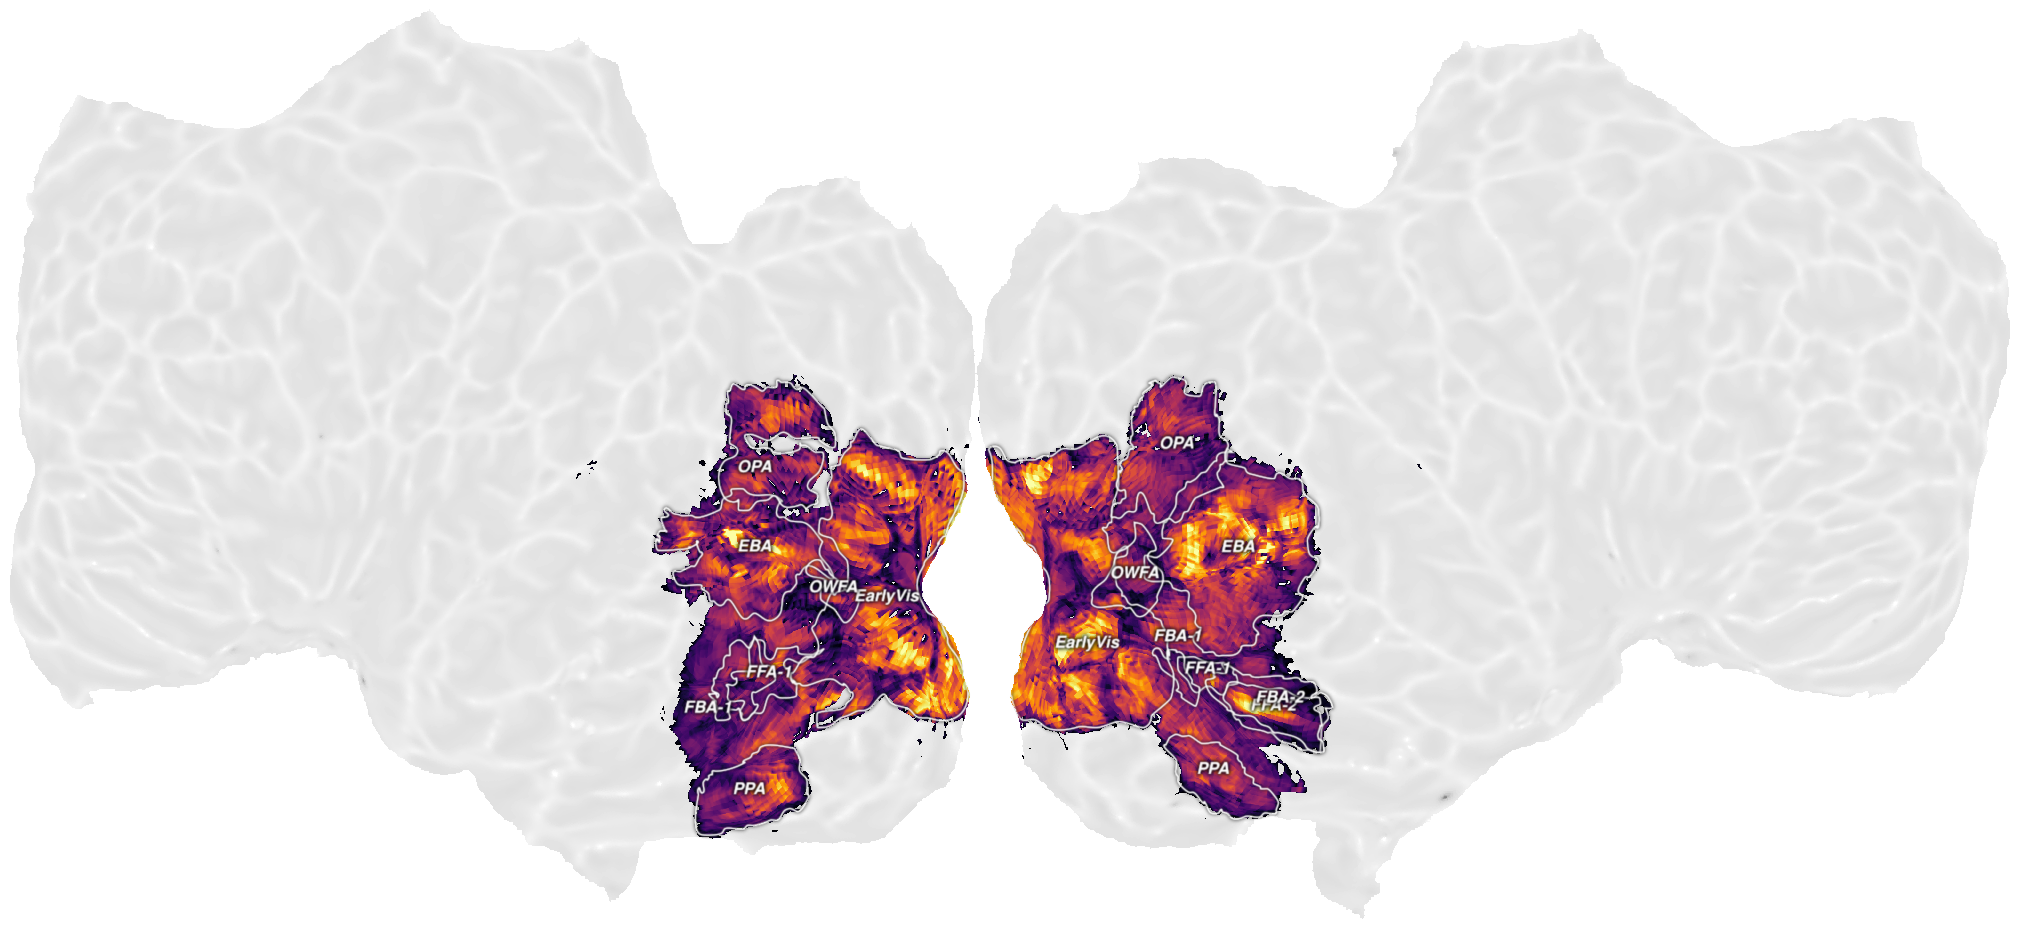

In [8]:
map_data = cortex.Volume(voxel_data, subj, xfmname=xfm, 
                         cmap=inferno_zero, 
                         vmin=0.0, vmax=1.0)

fig, plot_data = get_flatmap(map_data, with_rois=True, sampler='nearest')

### Flatmap From Voxel Metas

In [9]:
brain_data_dir = '../brain_data/voxel_sets/shared1000_OTC-only/'
metadata = pd.read_csv(f'{brain_data_dir}/voxel_metadata.csv')

def get_voxel_data_by_subj(subj, dataframe, fill='ncsnr', na_fill=np.nan):

    voxel_data = np.zeros(nsd_parser.get_subj_dims(subj))
    voxel_data[:] = na_fill

    for row_i, row in dataframe.iterrows():
        subj_i, x, y, z = row.name.split('-')

        if f'subj0{subj_i[1]}' == subj:
            x, y, z = int(x), int(y), int(z)
            voxel_data[x,y,z] = row[fill]

    return np.swapaxes(voxel_data.reshape(subj_dims),0,2)
    
voxel_data = get_voxel_data_by_subj(subj, metadata.set_index('voxel_id'), na_fill=0)

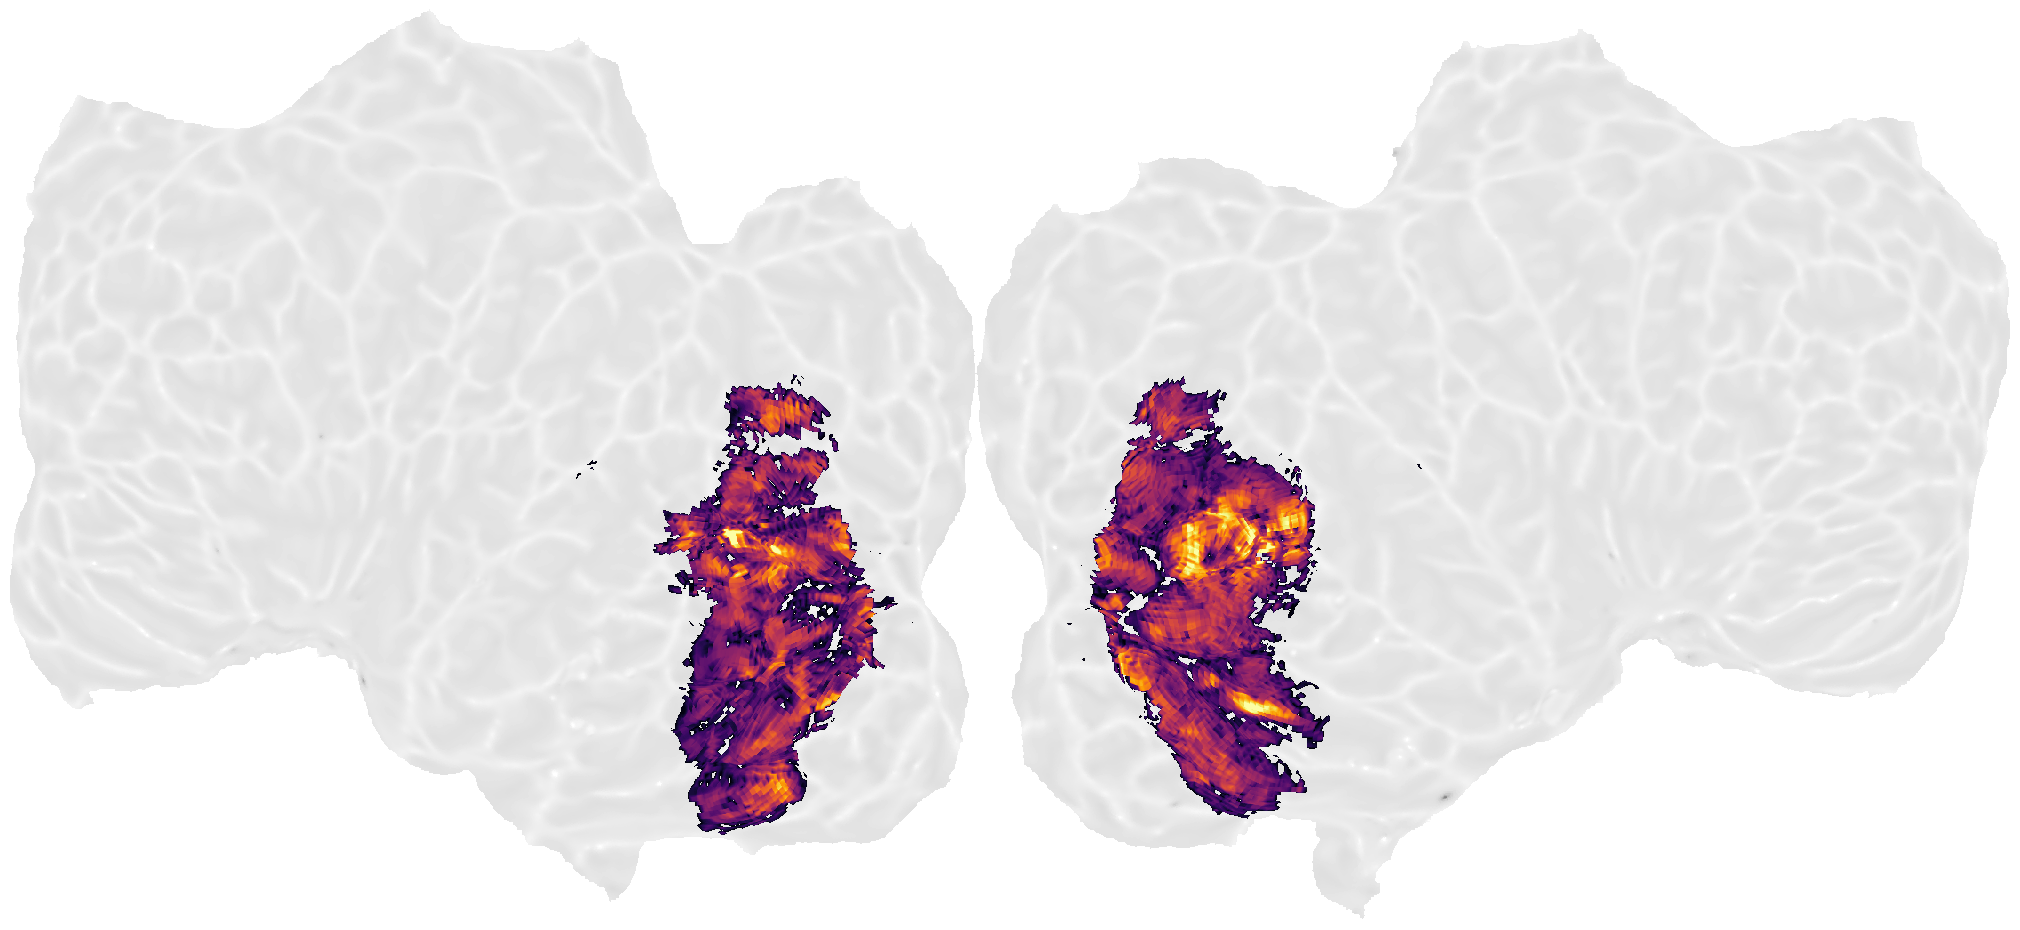

In [10]:
map_data = cortex.Volume(voxel_data, subj, xfmname=xfm, 
                         cmap=inferno_zero, 
                         vmin=0.0, vmax=1.0)

fig, plot_data = get_flatmap(map_data, with_rois=False, sampler='nearest')